Loaded dataset with shape: (9494, 21)
After preprocessing, shape: (9494, 24)

===== BASIC DATA SUMMARY =====
        arr_flights    arr_del15   delay_rate
count   9494.000000  9494.000000  9494.000000
mean     352.520539    82.927428     0.243082
std     1015.326033   236.552287     0.118336
min        0.000000     0.000000     0.000000
25%       50.000000    10.000000     0.169014
50%       94.000000    23.000000     0.233333
75%      238.000000    59.000000     0.305323
max    21854.000000  4877.000000     1.000000

===== PLOT 1: MONTHLY DELAY RATE =====


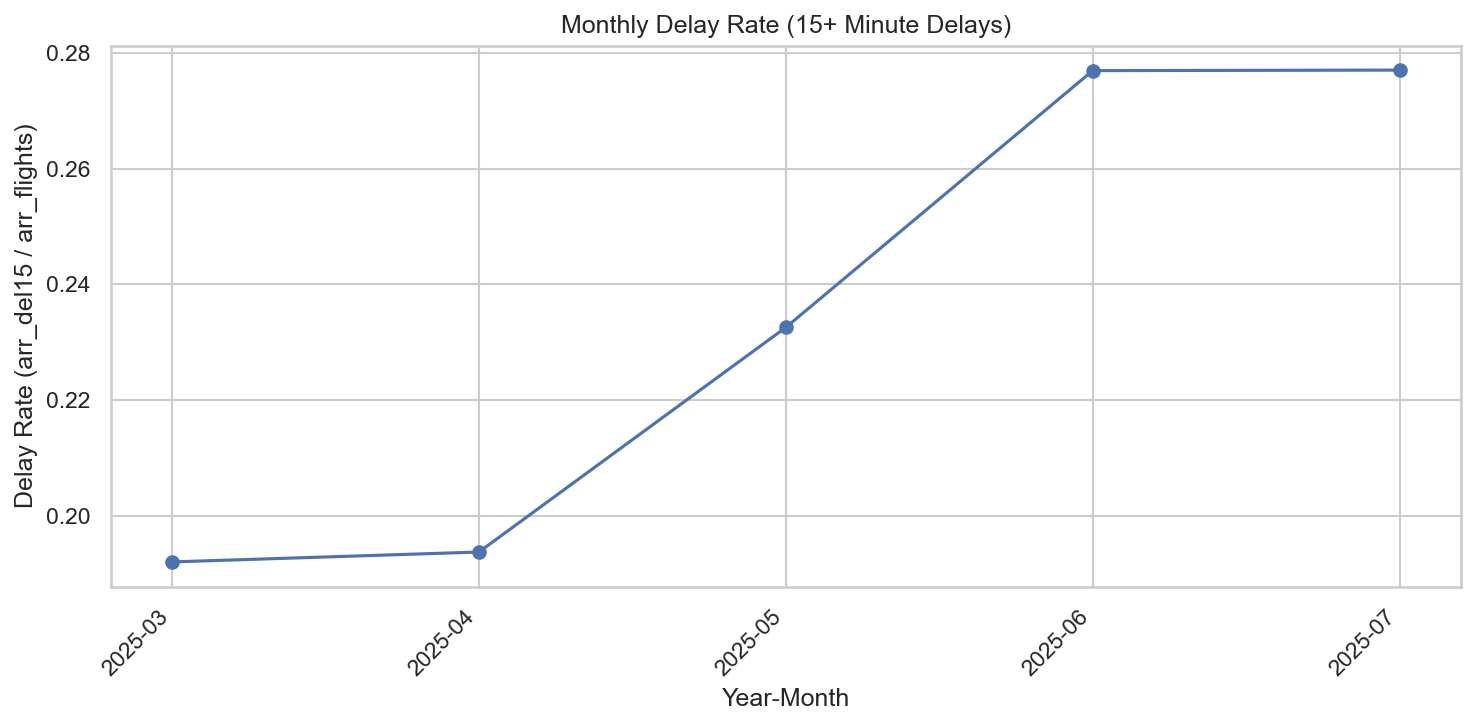


===== PLOT 2: DELAY CAUSE DISTRIBUTION =====


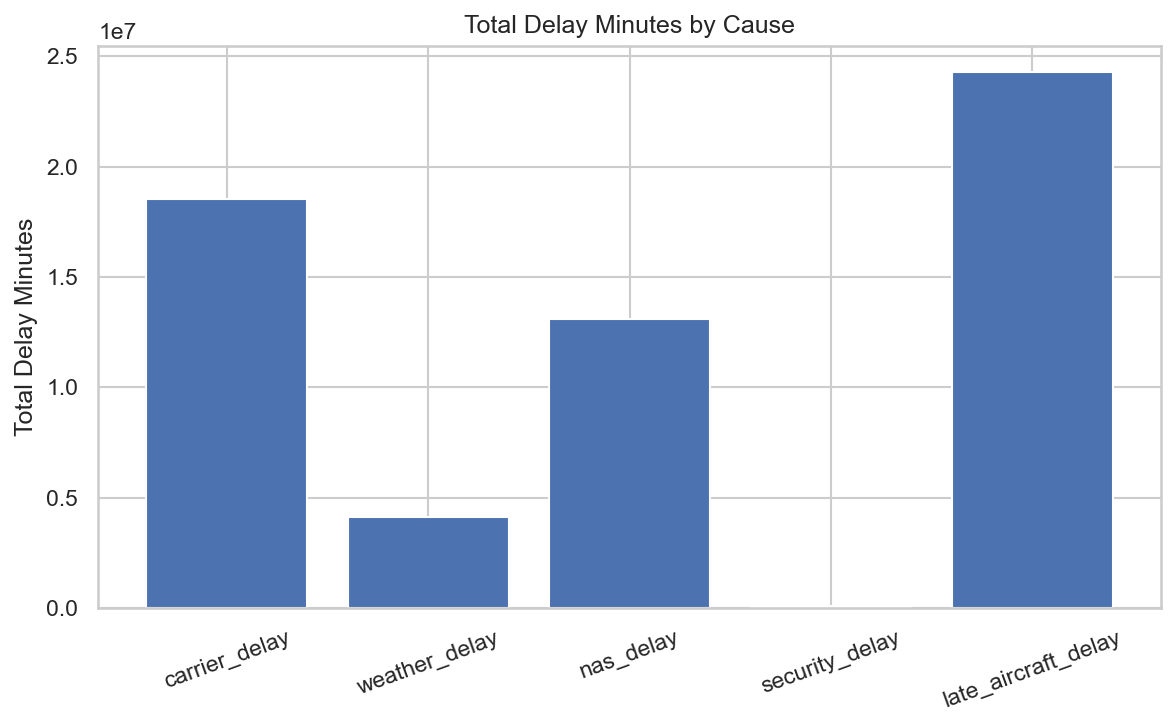


===== PLOT 3: CARRIER DELAY RATES =====


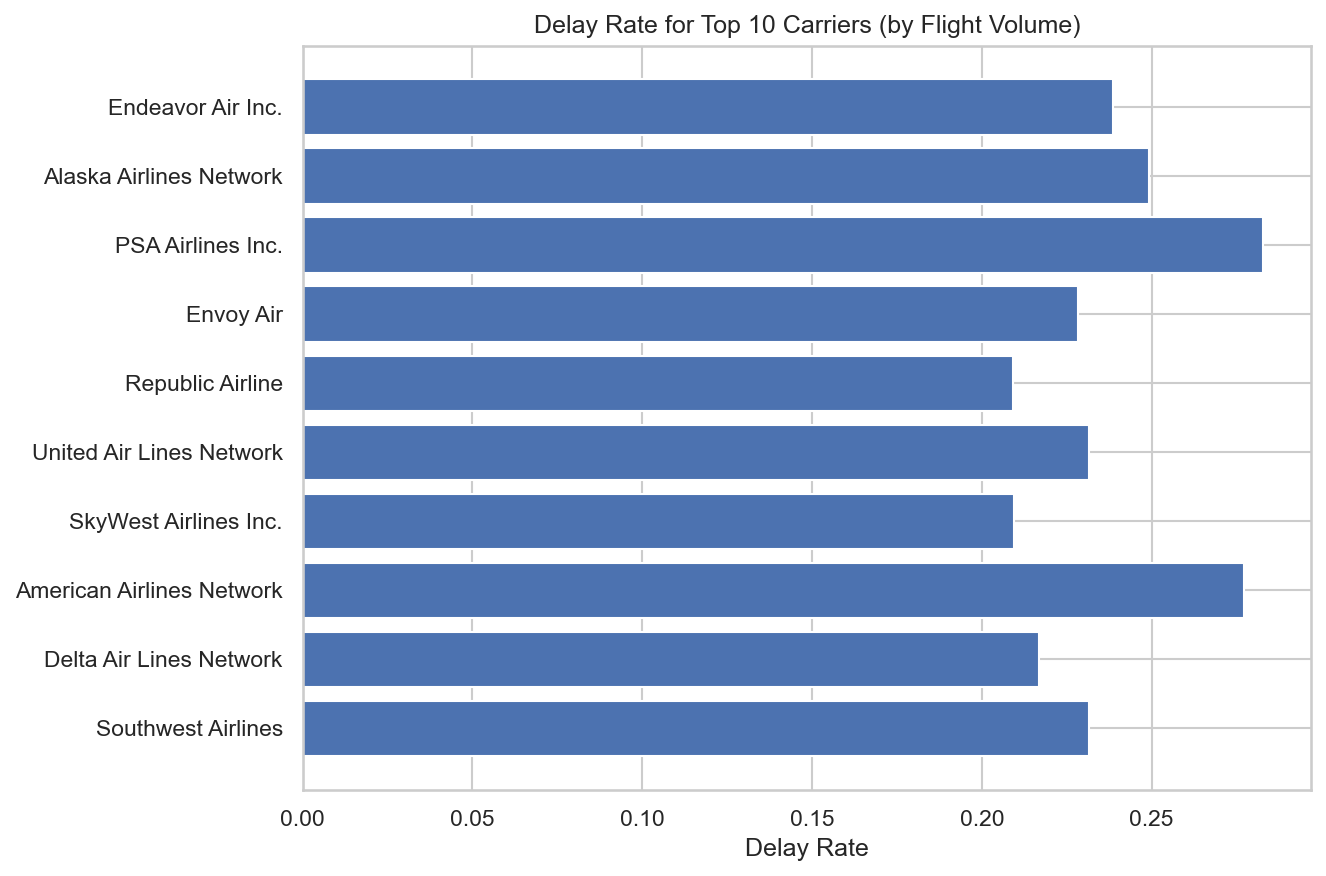


===== Logistic Regression RESULTS =====
Accuracy : 0.9723
Precision: 0.9723
Recall   : 1.0
F1-score : 0.9859

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.97      1.00      0.99      2770

    accuracy                           0.97      2849
   macro avg       0.49      0.50      0.49      2849
weighted avg       0.95      0.97      0.96      2849



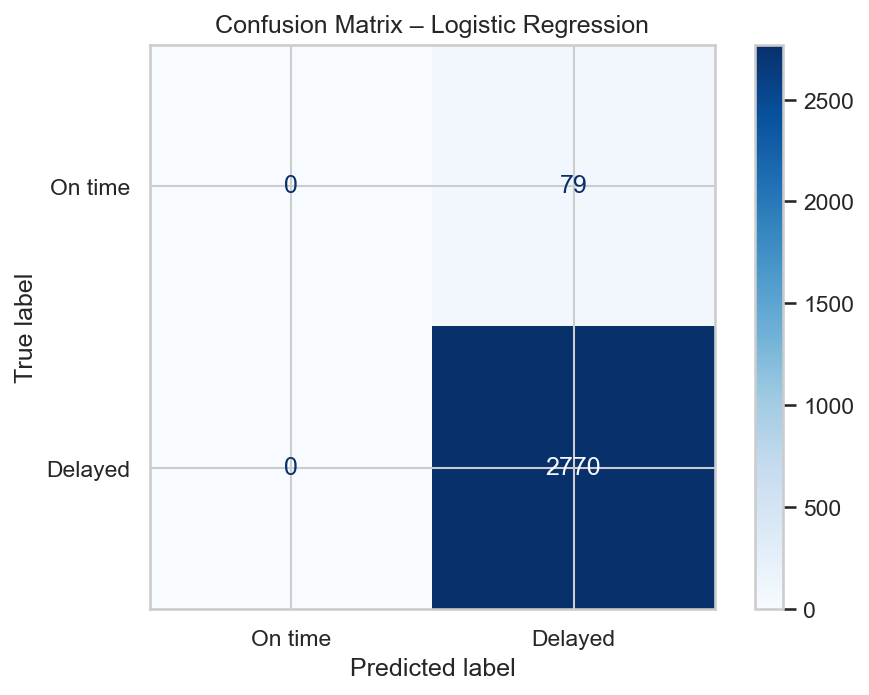


===== Random Forest RESULTS =====
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00      2770

    accuracy                           1.00      2849
   macro avg       1.00      1.00      1.00      2849
weighted avg       1.00      1.00      1.00      2849



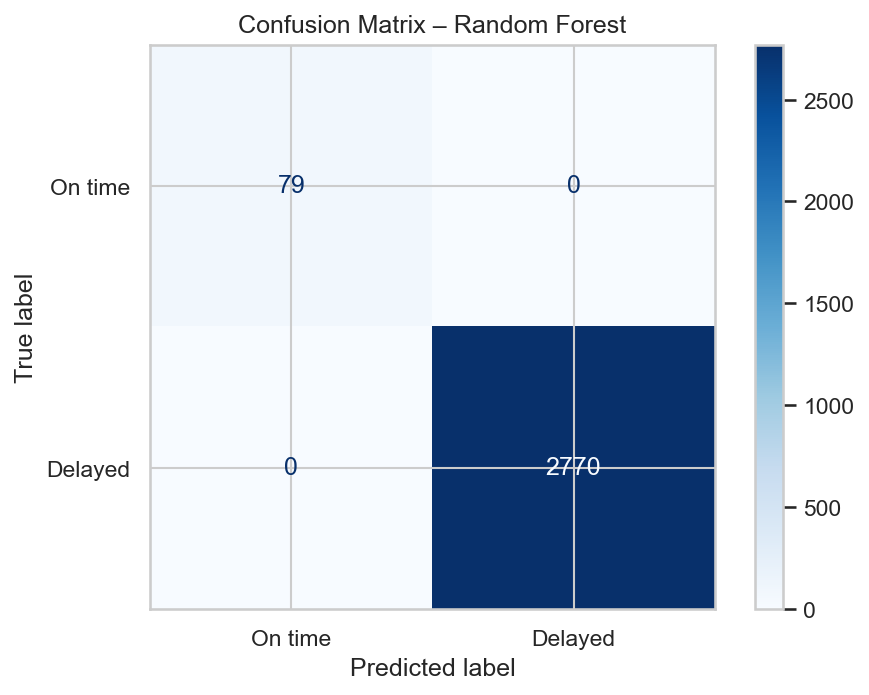


===== Gradient Boosting RESULTS =====
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00      2770

    accuracy                           1.00      2849
   macro avg       1.00      1.00      1.00      2849
weighted avg       1.00      1.00      1.00      2849



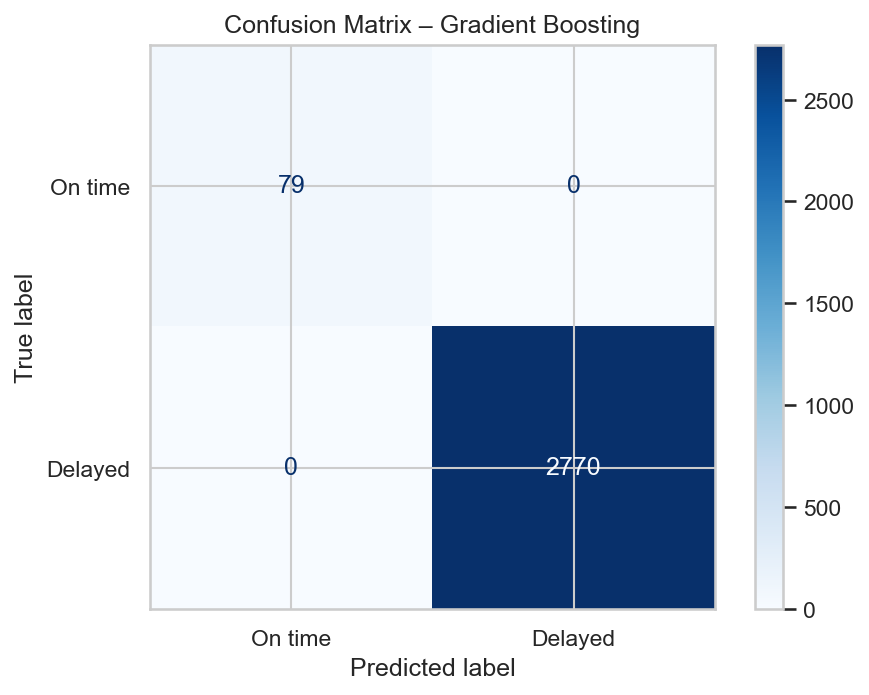

In [4]:
# flight_delay_analysis.ipynb
# CAP 4770 Final Project – Flight Delay Prediction
# Group: Ryan Blankenbeker, Kenyen Hast-Otero, John WG Wallace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

plt.rcParams["figure.dpi"] = 150
sns.set(style="whitegrid")


# -------------------------------------------------------------------
# 1. DATA LOADING & PREPROCESSING
# -------------------------------------------------------------------

def load_data(csv_path: str) -> pd.DataFrame:
    """
    Load the airline delay data from a CSV file.

    Parameters
    ----------
    csv_path : str
        Path to the Airline_Delay_Cause.csv file.

    Returns
    -------
    df : pd.DataFrame
        Raw dataframe.
    """
    df = pd.read_csv(csv_path)
    return df


def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and engineer features for analysis and modeling.

    Steps:
    - Remove duplicate rows
    - Create year_month field
    - Fill missing numeric values with 0
    - Create delay_rate feature
    - Create binary label is_delayed based on arr_del15

    Parameters
    ----------
    df : pd.DataFrame
        Raw dataframe.

    Returns
    -------
    df : pd.DataFrame
        Preprocessed dataframe.
    """
    # Remove duplicates
    df = df.drop_duplicates()

    # Create YYYY-MM field for trend analysis
    df["year_month"] = df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)

    # Identify numeric columns and fill missing with 0
    numeric_cols = df.select_dtypes(include=["float64", "int64", "int32"]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0)

    # Avoid division by zero when computing delay_rate
    df["delay_rate"] = df["arr_del15"] / df["arr_flights"].replace(0, 1)

    # Binary label: 1 if any 15+ minute delays occurred, else 0
    df["is_delayed"] = (df["arr_del15"] > 0).astype(int)

    return df


# -------------------------------------------------------------------
# 2. VISUALIZATIONS
# -------------------------------------------------------------------

def plot_monthly_delay_rate(df: pd.DataFrame) -> None:
    """
    Plot the monthly delay rate over time.
    """
    monthly = df.groupby("year_month")[["arr_flights", "arr_del15"]].sum()
    monthly["delay_rate"] = monthly["arr_del15"] / monthly["arr_flights"].replace(0, 1)

    plt.figure(figsize=(10, 5))
    plt.plot(monthly.index, monthly["delay_rate"], marker="o")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Delay Rate (arr_del15 / arr_flights)")
    plt.xlabel("Year-Month")
    plt.title("Monthly Delay Rate (15+ Minute Delays)")
    plt.tight_layout()
    plt.show()


def plot_delay_cause_distribution(df: pd.DataFrame) -> None:
    """
    Plot total delay minutes for each cause.
    """
    cause_cols = ["carrier_delay", "weather_delay", "nas_delay",
                  "security_delay", "late_aircraft_delay"]

    cause_sum = df[cause_cols].sum()

    plt.figure(figsize=(8, 5))
    plt.bar(cause_sum.index, cause_sum.values)
    plt.ylabel("Total Delay Minutes")
    plt.title("Total Delay Minutes by Cause")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


def plot_carrier_delay_rates(df: pd.DataFrame, top_n: int = 10) -> None:
    """
    Plot delay rate by carrier for the top N carriers by flight volume.
    """
    carrier_stats = df.groupby("carrier_name")[["arr_del15", "arr_flights"]].sum()
    carrier_stats["delay_rate"] = carrier_stats["arr_del15"] / carrier_stats["arr_flights"].replace(0, 1)

    top = carrier_stats.sort_values("arr_flights", ascending=False).head(top_n)

    plt.figure(figsize=(9, 6))
    plt.barh(top.index, top["delay_rate"])
    plt.xlabel("Delay Rate")
    plt.title(f"Delay Rate for Top {top_n} Carriers (by Flight Volume)")
    plt.tight_layout()
    plt.show()


def explore_data(df: pd.DataFrame) -> None:
    """
    Run the core EDA pipeline: print summaries and generate plots.
    """
    print("\n===== BASIC DATA SUMMARY =====")
    print(df[["arr_flights", "arr_del15", "delay_rate"]].describe())

    print("\n===== PLOT 1: MONTHLY DELAY RATE =====")
    plot_monthly_delay_rate(df)

    print("\n===== PLOT 2: DELAY CAUSE DISTRIBUTION =====")
    plot_delay_cause_distribution(df)

    print("\n===== PLOT 3: CARRIER DELAY RATES =====")
    plot_carrier_delay_rates(df, top_n=10)


# -------------------------------------------------------------------
# 3. MODELING – PREDICTING 15+ MINUTE DELAYS
# -------------------------------------------------------------------

def get_feature_matrix_and_labels(df: pd.DataFrame):
    """
    Build feature matrix X and label vector y.

    We focus on delay-related numeric features. You could add
    encoded carrier/airport info later if desired.
    """
    feature_cols = [
        "carrier_ct", "weather_ct", "nas_ct", "security_ct", "late_aircraft_ct",
        "arr_delay", "carrier_delay", "weather_delay", "nas_delay",
        "security_delay", "late_aircraft_delay"
    ]

    X = df[feature_cols].copy()
    y = df["is_delayed"].copy()

    return X, y


def scale_features(X_train: pd.DataFrame, X_test: pd.DataFrame):
    """
    Standardize numeric features (important for some models).
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler


def evaluate_model(name: str, y_true, y_pred) -> None:
    """
    Print evaluation metrics and confusion matrix for a classifier.
    """
    print(f"\n===== {name} RESULTS =====")
    print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
    print("Precision:", round(precision_score(y_true, y_pred, zero_division=0), 4))
    print("Recall   :", round(recall_score(y_true, y_pred, zero_division=0), 4))
    print("F1-score :", round(f1_score(y_true, y_pred, zero_division=0), 4))
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["On time", "Delayed"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix – {name}")
    plt.tight_layout()
    plt.show()


def run_models(df: pd.DataFrame) -> None:
    """
    Train and evaluate multiple classification models.
    """
    X, y = get_feature_matrix_and_labels(df)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    X_train_scaled, X_test_scaled, _ = scale_features(X_train, X_test)

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=500),
        "Random Forest": RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1
        ),
        "Gradient Boosting": GradientBoostingClassifier(
            random_state=42
        ),
    }

    # Train and evaluate
    for name, model in models.items():
        if "Logistic" in name or "Gradient" in name:
            model.fit(X_train_scaled, y_train)
            preds = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

        evaluate_model(name, y_test, preds)


# -------------------------------------------------------------------
# 4. MAIN
# -------------------------------------------------------------------

def main():
    # 1. Load data
    csv_path = "Airline_Delay_Cause.csv"  # adjust path if needed
    df_raw = load_data(csv_path)
    print("Loaded dataset with shape:", df_raw.shape)

    # 2. Preprocess
    df = preprocess(df_raw)
    print("After preprocessing, shape:", df.shape)

    # 3. Explore the data (plots + summaries)
    explore_data(df)

    # 4. Run predictive models
    run_models(df)


if __name__ == "__main__":
    main()
